In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from glob import glob
import os
import csv
    
import pandas as pd
import numpy as np

from clinical_preprocess import preprocess_clinical_df
from data_loader import get_pids_split
from surv_model_utils import *
from results_utils import *

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, KFold

from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)
from sksurv.ensemble import RandomSurvivalForest
import sksurv.datasets as skds

import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt

In [3]:
### UPDATE THESE BEFORE RUNNING
data_root = '../data/' # Location of PIDS (pids.txt)
csv_path = '../data/' # Location of nlst_15kpct_prsn_062119.csv'
file_list = glob('../data/pyradiomics_features/'+'/*') # Location of the pyradiomics features
radiomics_feature_name_file = '../data/' #Location of pyradiomics_features.txt
result_file = 'results.txt'
subset_file = 'subset.txt'

#data_root = '/mnt/nlst/' # Location of PIDS (pids.txt)
#csv_path = '/mnt/nlst/package-nlst-512.2019-08-13/CT_and_Path_w_CT/' # Location of nlst_15kpct_prsn_062119.csv'
#file_list = glob('/mnt/data0-nfs/shared-datasets/cancer_multimodal/nlst/pyradiomics_features/'+'/*') # Location of the pyradiomics features
#radiomics_feature_name_file = '/mnt/data0-nfs/shared-datasets/cancer_multimodal/nlst/'

matplotlib.rcParams.update({'font.size': 18})
random_state = 20
np.random_state = 20

In [4]:
def visualize_data(x, y, title): 
    fig_num, axes_num = plt.subplots(len(x.columns)-len(categorical_vars), 1, figsize=(6, 10))
    fig_num.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_num.suptitle(title + " - x numerical variables", size=12)
    i_num = 0
    
    fig_cat, axes_cat = plt.subplots(len(categorical_vars), 1, figsize=(6, 36))
    fig_cat.tight_layout(rect=[0, 0.01, 1, 0.97])
    fig_cat.suptitle(title + " - x categorial variables", size=12)
    i_cat = 0

    for column in x.columns:
        if column in categorical_vars: 
            num_ones = np.sum(x[column])
            length = len(x[column])
            axes_cat[i_cat].bar(x=[0,1], height=[length - num_ones, num_ones], align='center')
            axes_cat[i_cat].set_title("column name: {}".format(column), size=12)
            i_cat += 1
        else:
            axes_num[i_num].plot(x[column], np.zeros(len(x[column])), "o")
            axes_num[i_num].errorbar([np.mean(x[column])], [0], xerr=np.std(x[column]), capsize=20, color='k')
            axes_num[i_num].plot([np.mean(x[column])], [0], 'x', markersize=20, color='k')
            axes_num[i_num].set_title("column name: {}".format(column), size=12)
            i_num += 1
    
    events = []
    durations = []
    for (e, d) in y: 
        events.append(e)
        durations.append(d)
    num_deaths = np.sum(events)
    y_length = len(events)
    
    fig_y, axes_y = plt.subplots(2, 1, figsize=(6,6))
    fig_y.suptitle(title + " - y", size=12)
    axes_y[0].bar(x=[0,1], height=[y_length - num_deaths, num_deaths], align='center')
    axes_y[0].set_title("num deaths", size=12)
    
    axes_y[1].plot(durations, np.zeros(len(durations)), "o")
    axes_y[1].errorbar([np.mean(durations)], [0], xerr=np.std(durations), capsize=20, color='k')
    axes_y[1].plot([np.mean(durations)], [0], 'x', markersize=20, color='k')
    axes_y[1].set_title("duration until death", size=12)
    fig_y.tight_layout(rect=[0, 0.01, 1, 0.99])

/Users/mollydasso/Code/survival_nlst/survival_nlst_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='../data/pids.txt' mode='r' encoding='UTF-8'>
  """Entry point for launching an IPython kernel.
/Users/mollydasso/Code/survival_nlst/survival_nlst_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (201,224,225,328,330,331,332,333,334) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Clinical only:


/Users/mollydasso/Code/survival_nlst/survival_nlst_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (201,224,225,328,330,331,332,333,334) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Clinical only:


/Users/mollydasso/Code/survival_nlst/survival_nlst_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (201,224,225,328,330,331,332,333,334) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Clinical only:


/Users/mollydasso/Code/survival_nlst/survival_nlst_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (201,224,225,328,330,331,332,333,334) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Clinical only:


/Users/mollydasso/Code/survival_nlst/survival_nlst_env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/mollydasso/Code/survival_nlst/survival_nlst_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (201,224,225,328,330,331,332,333,334) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Clinical only:


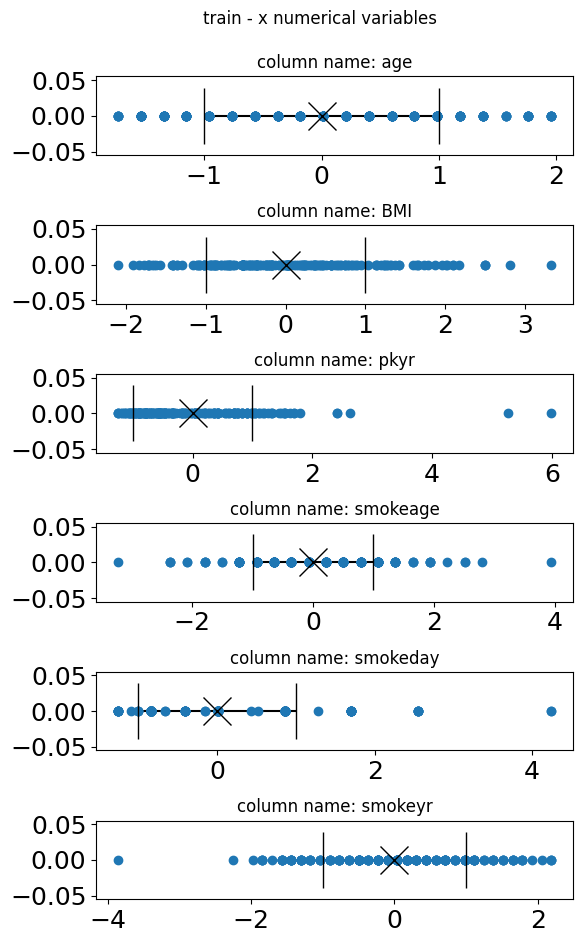

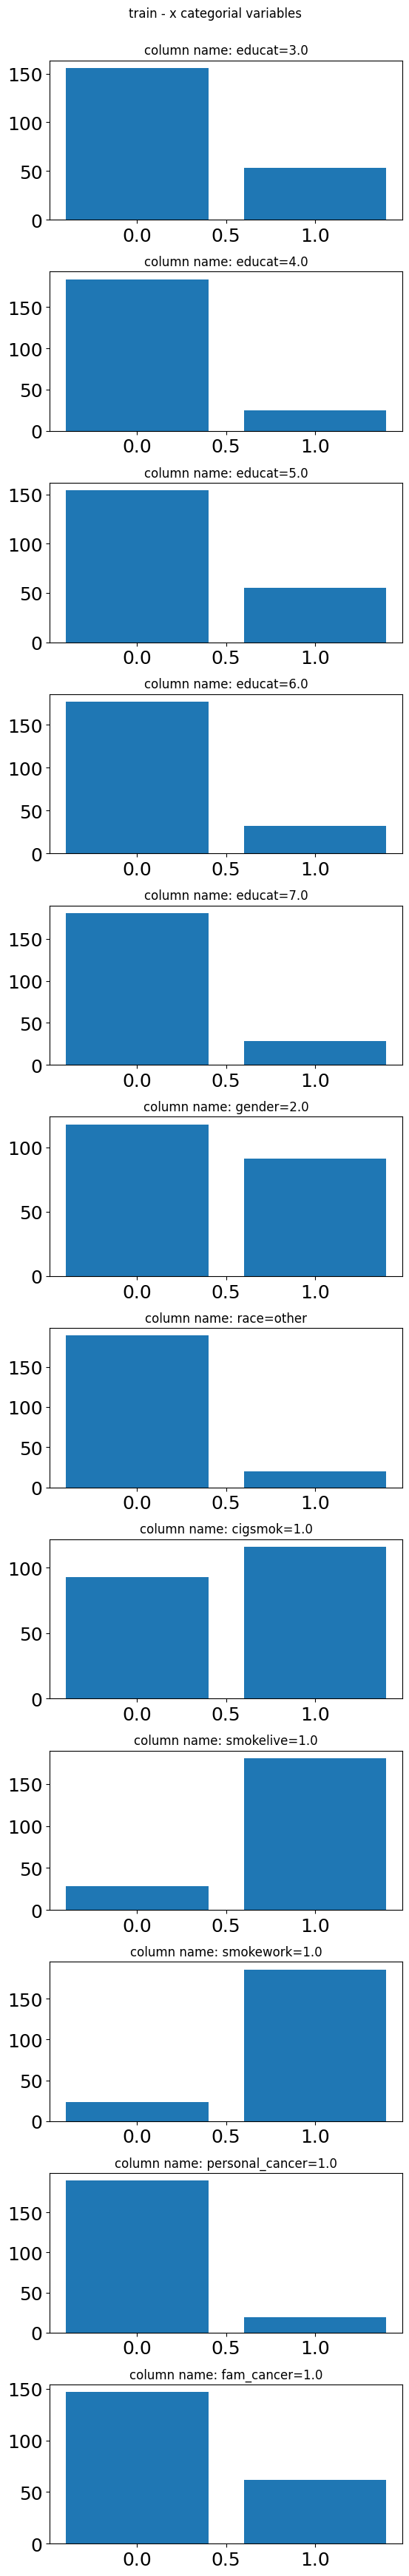

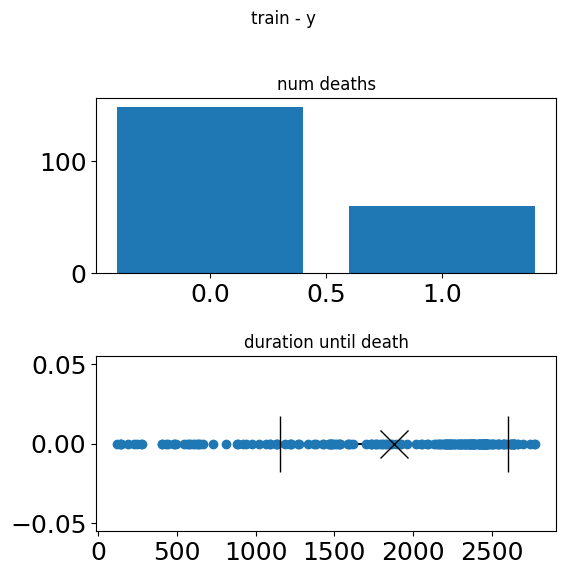

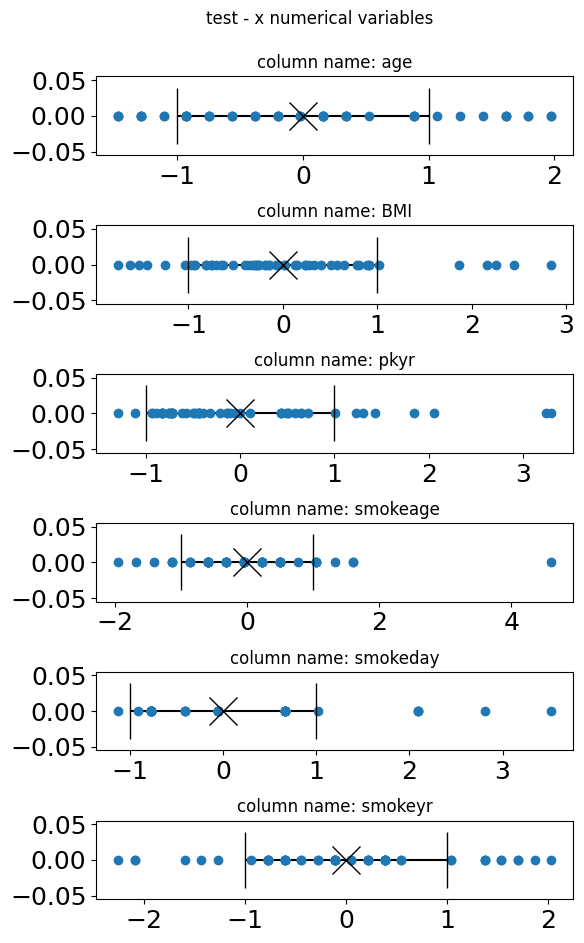

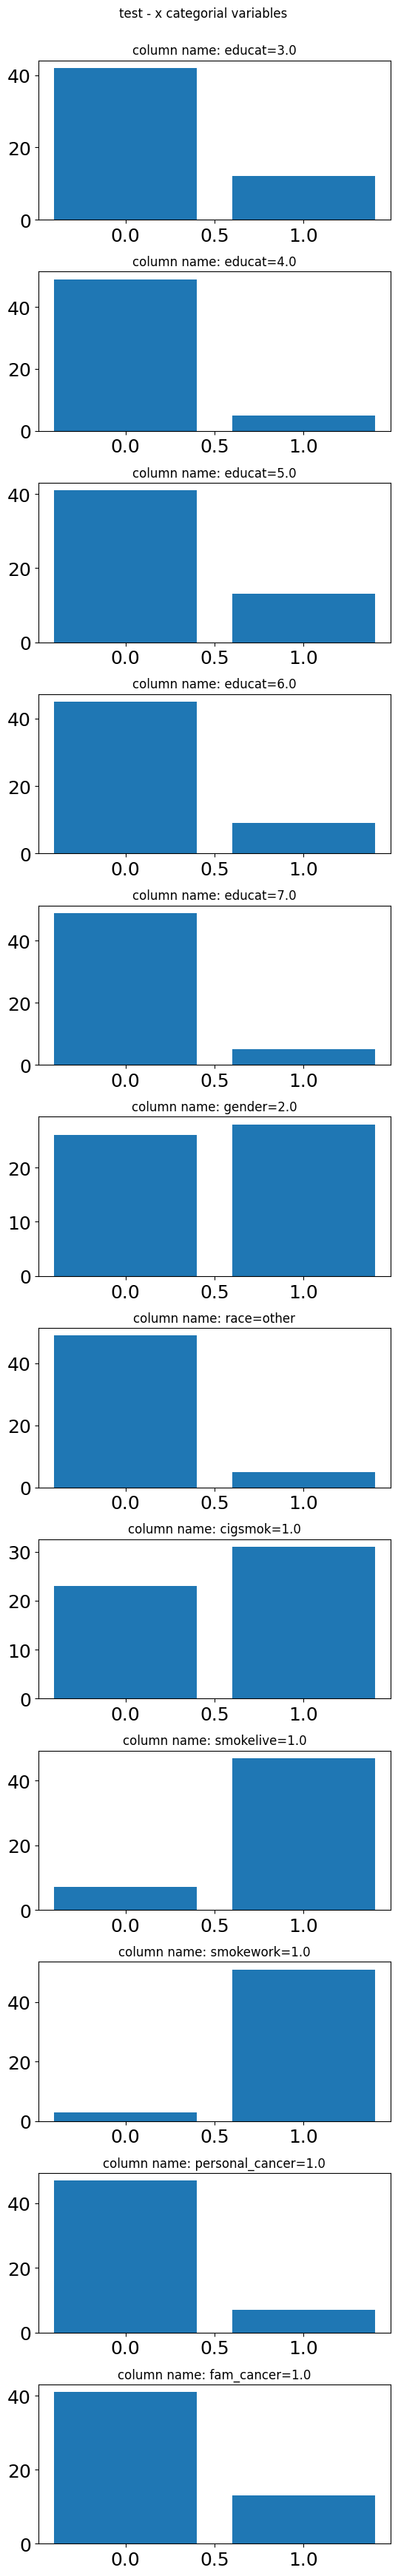

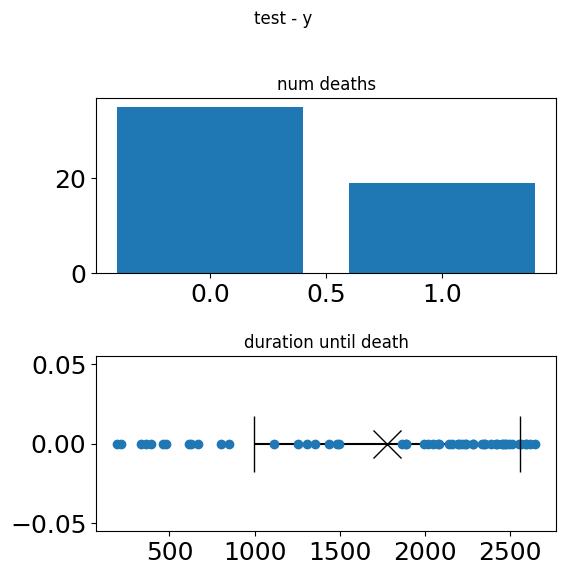

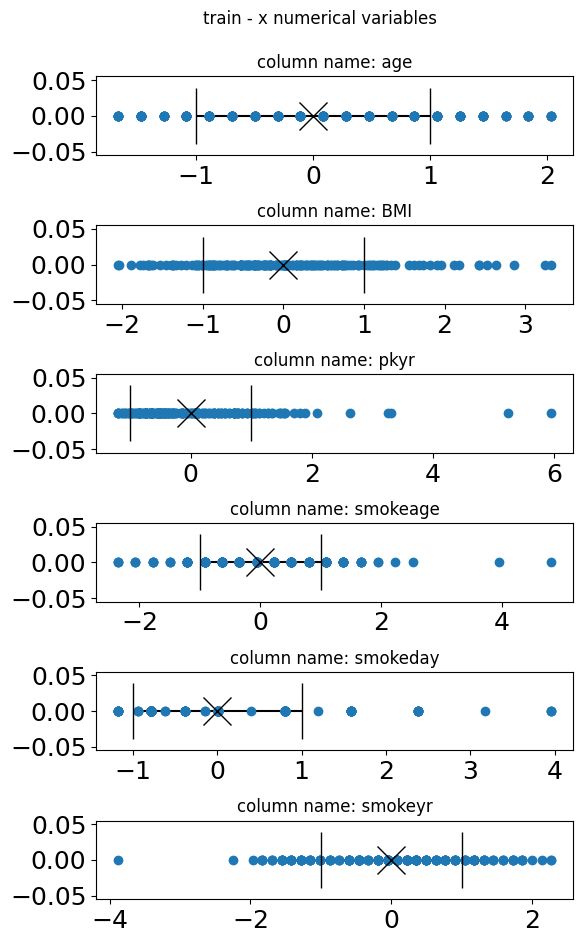

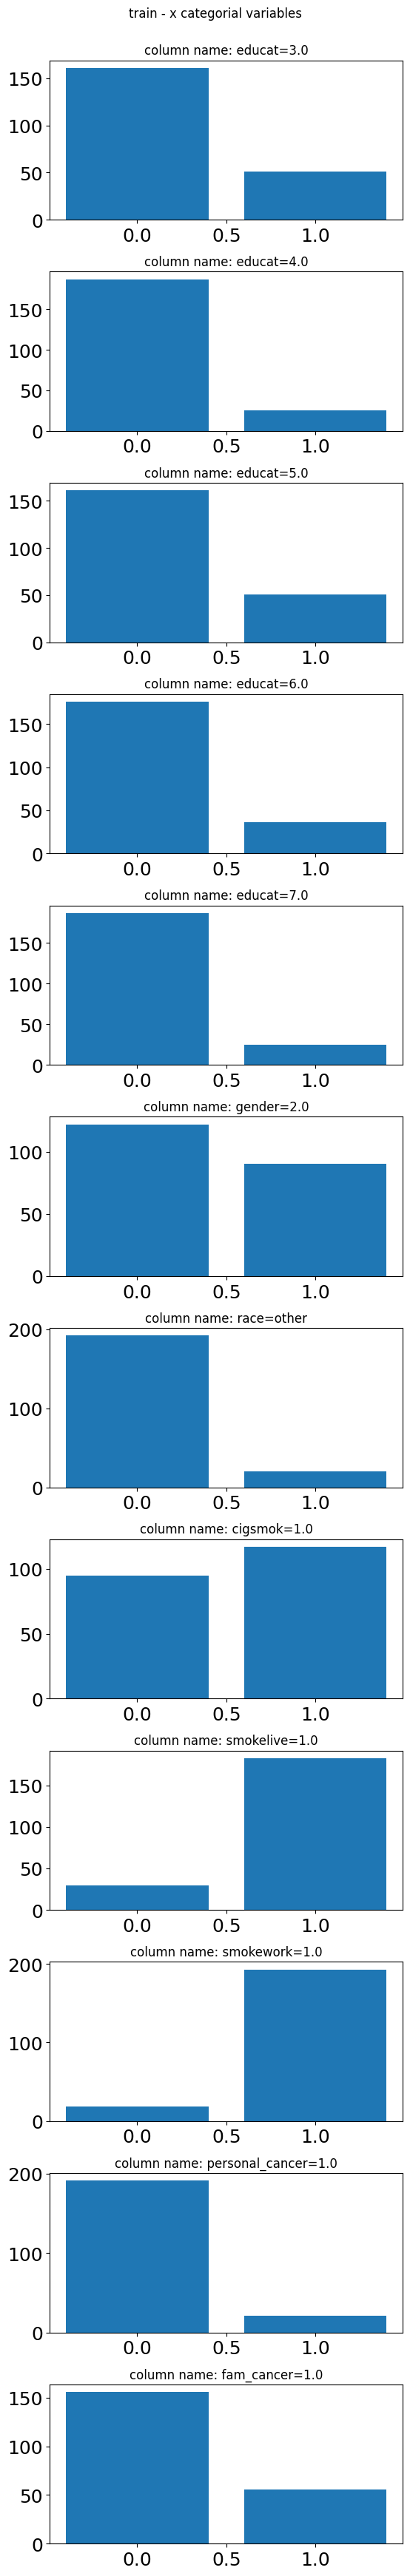

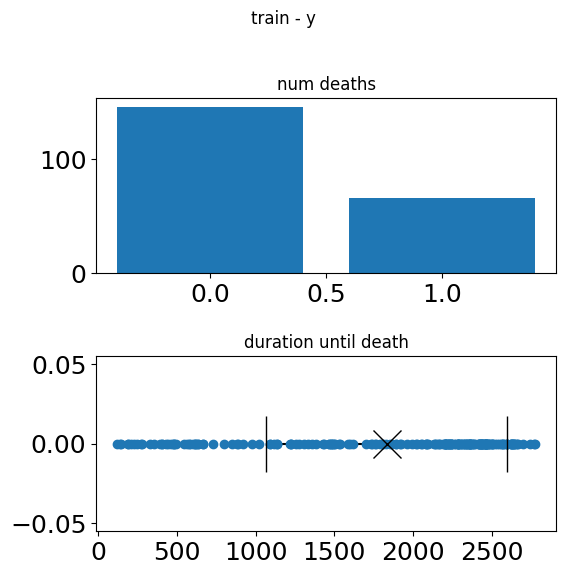

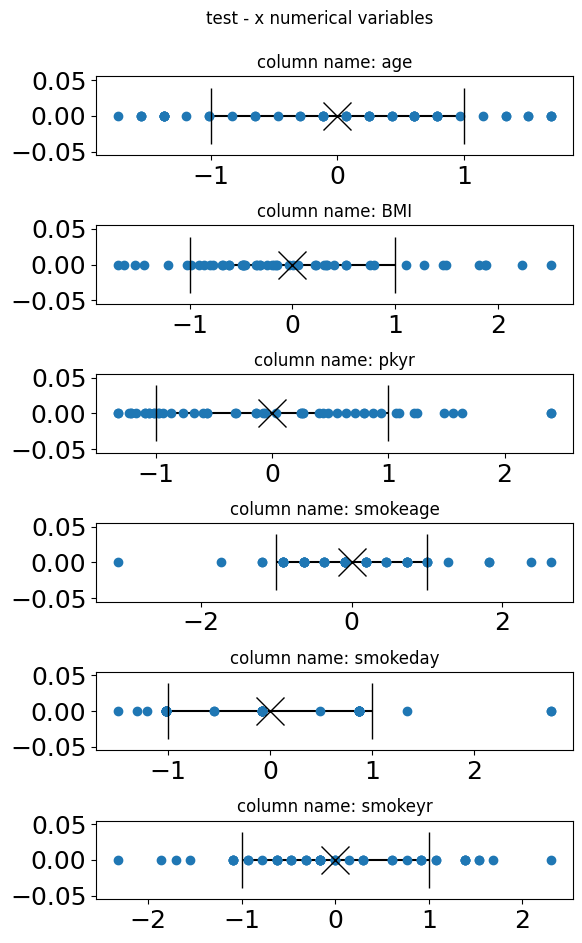

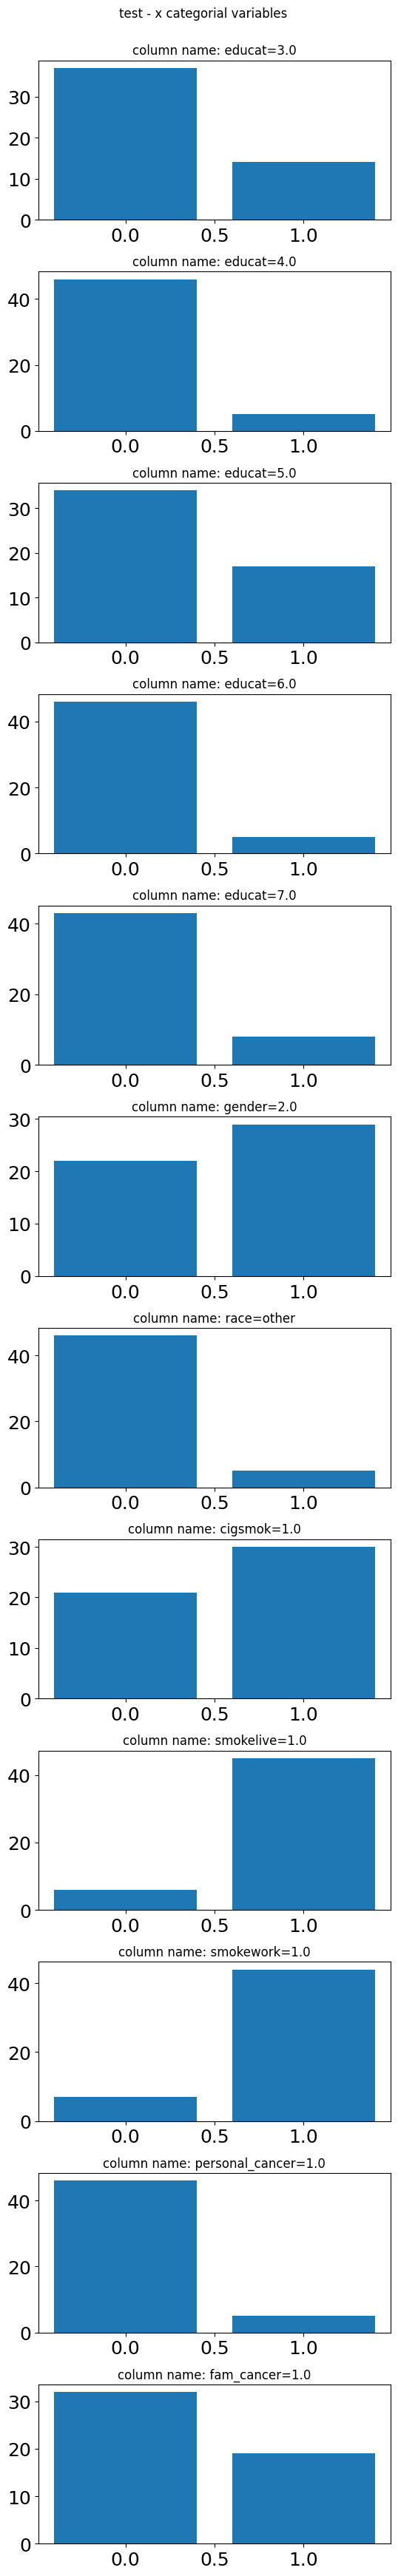

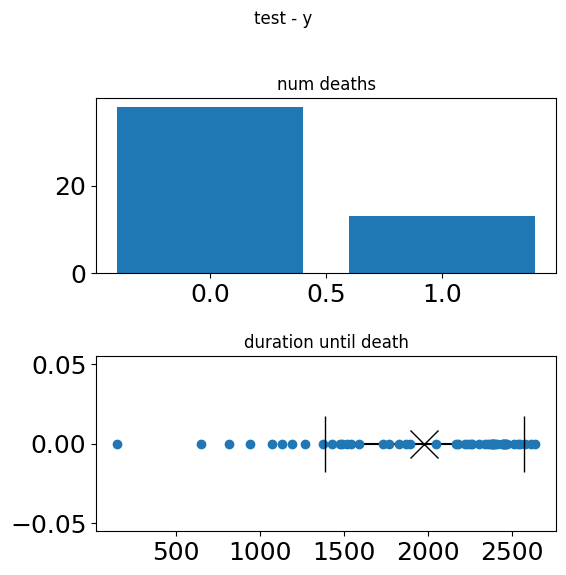

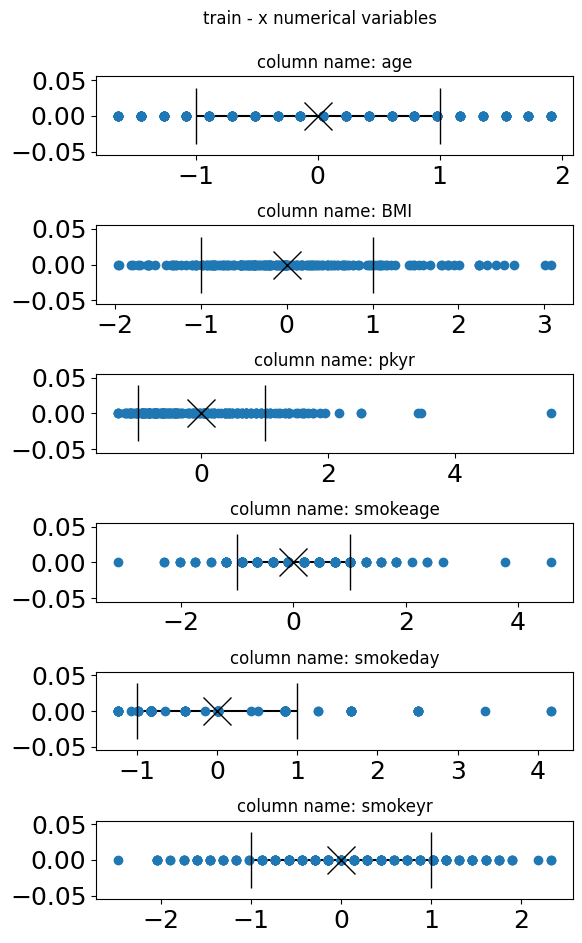

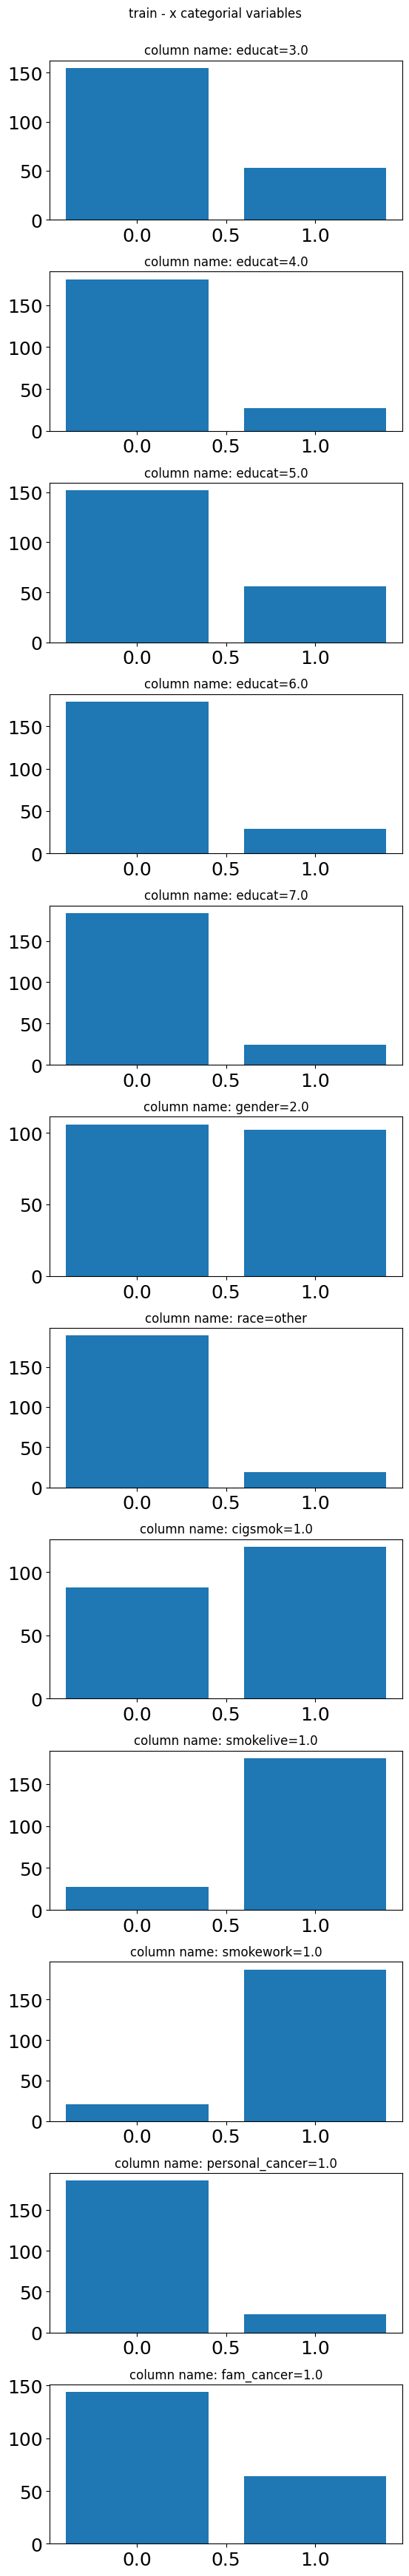

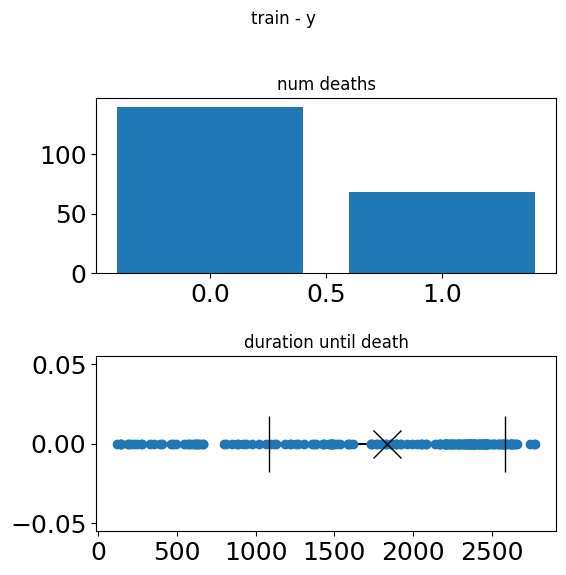

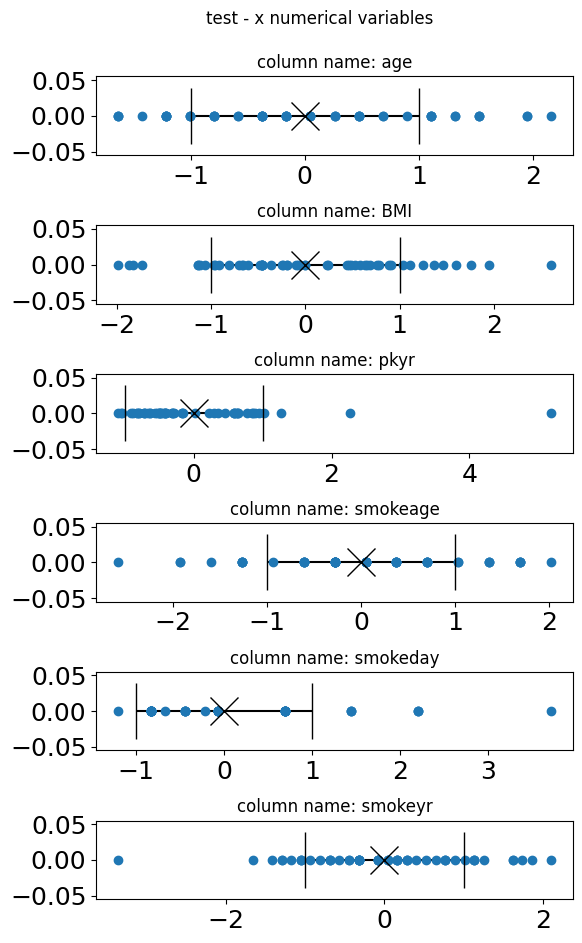

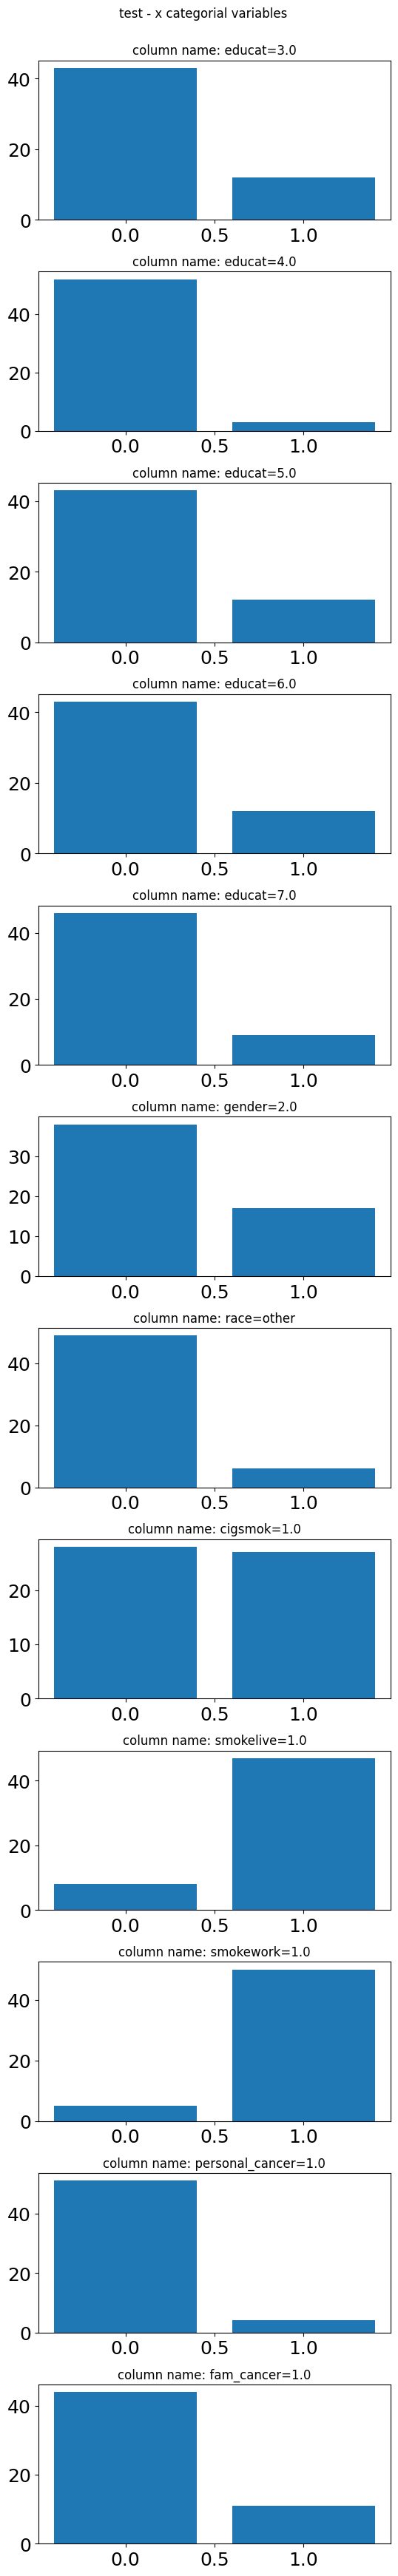

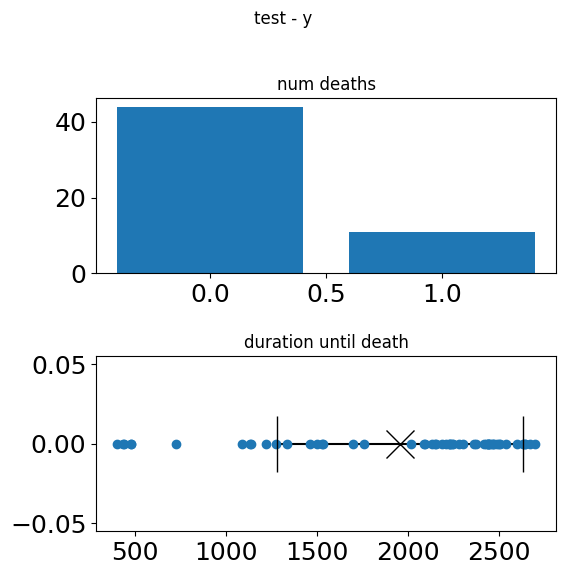

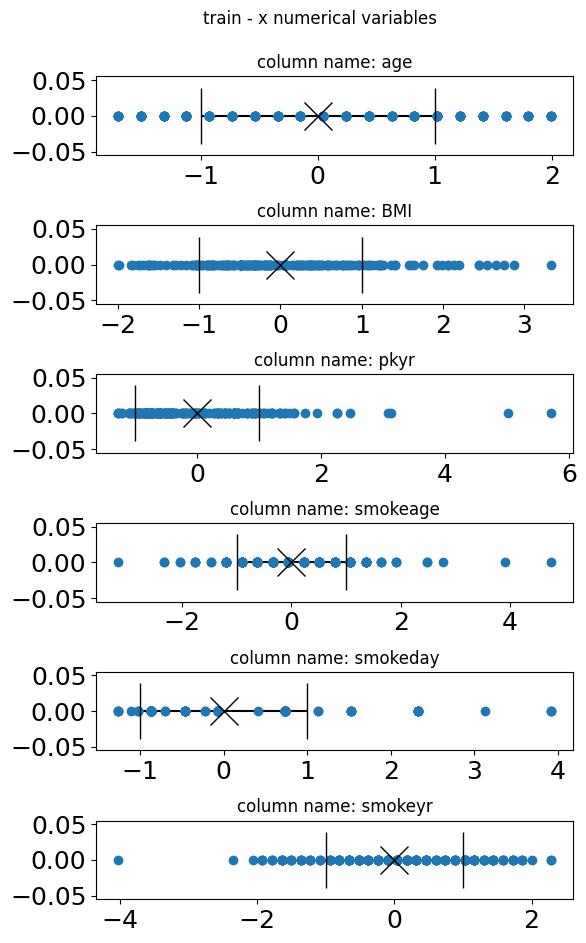

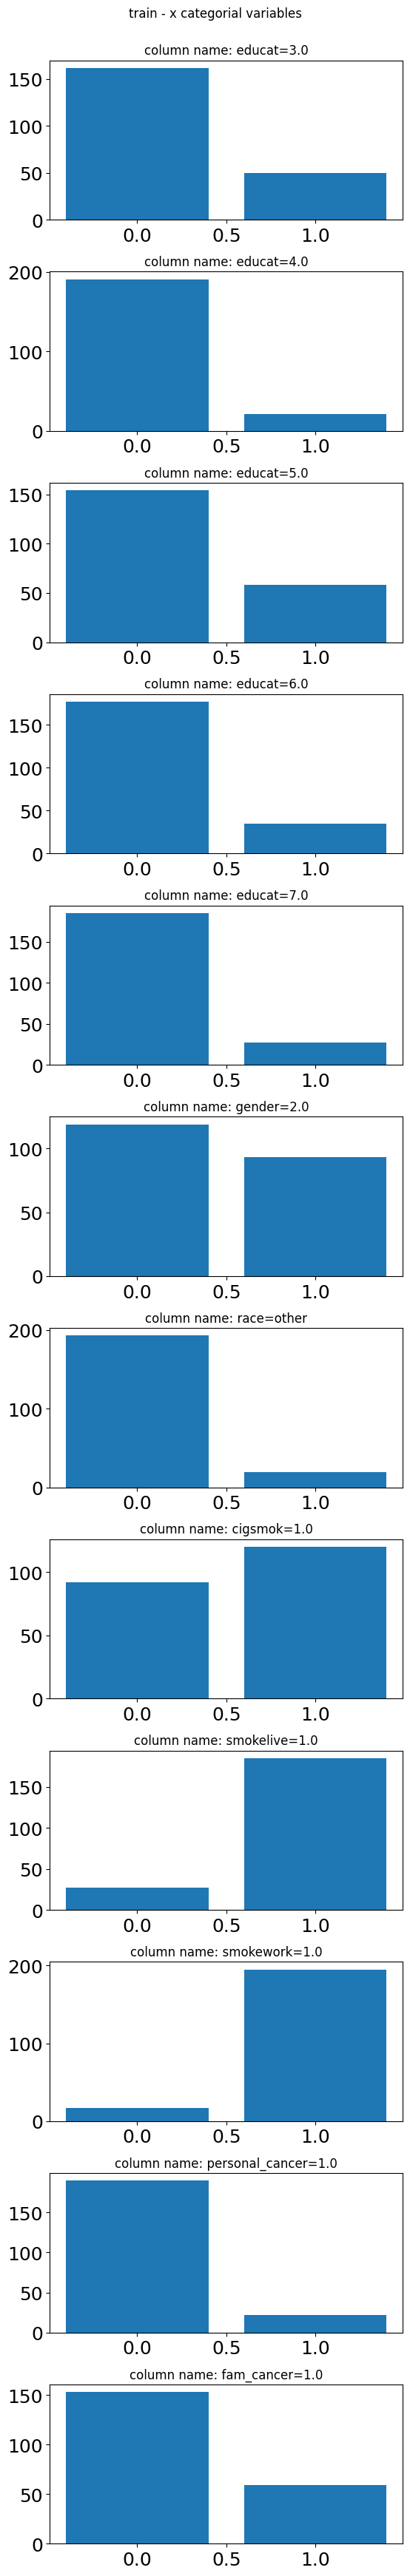

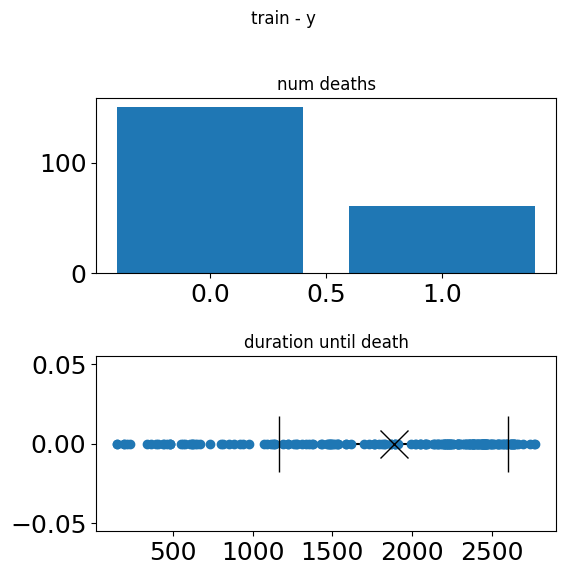

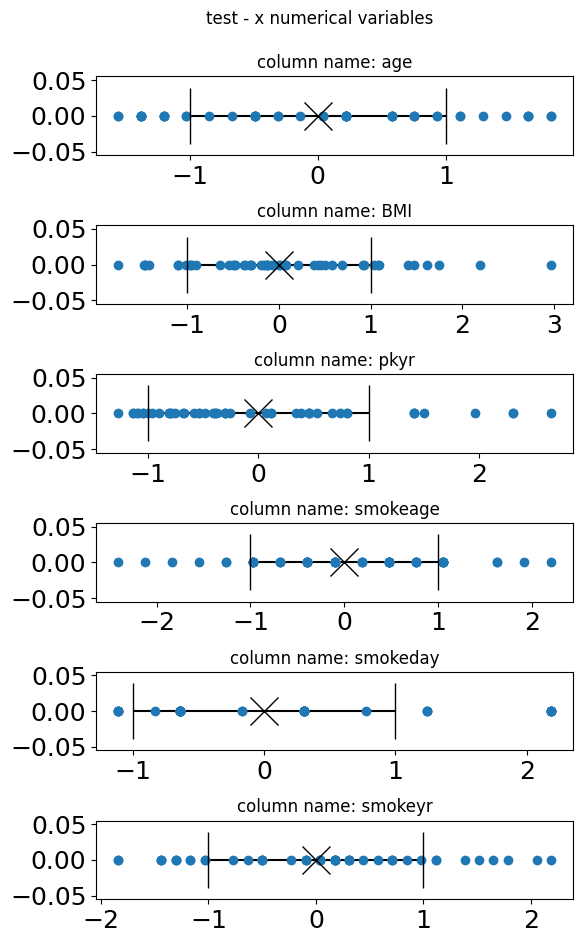

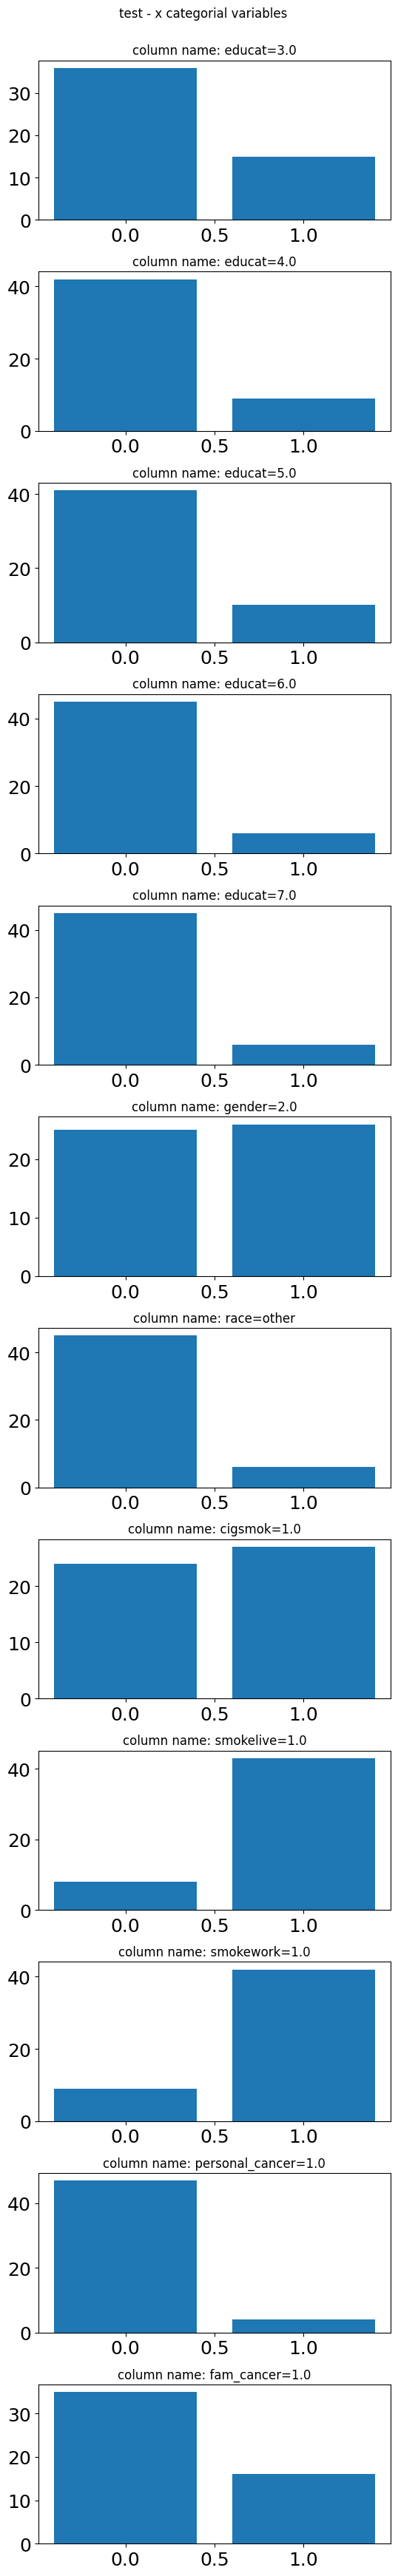

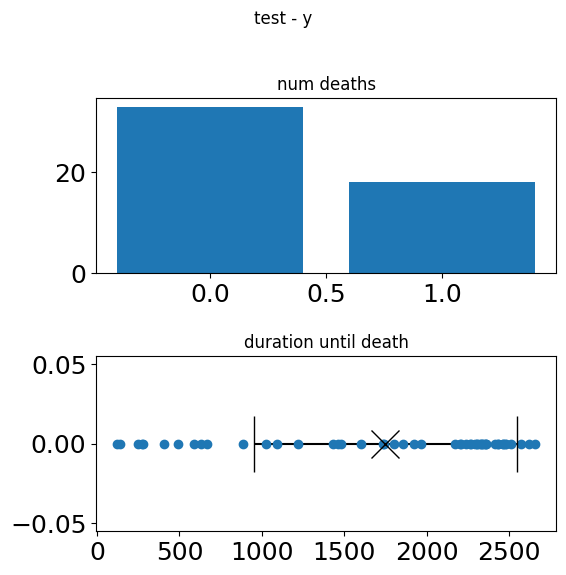

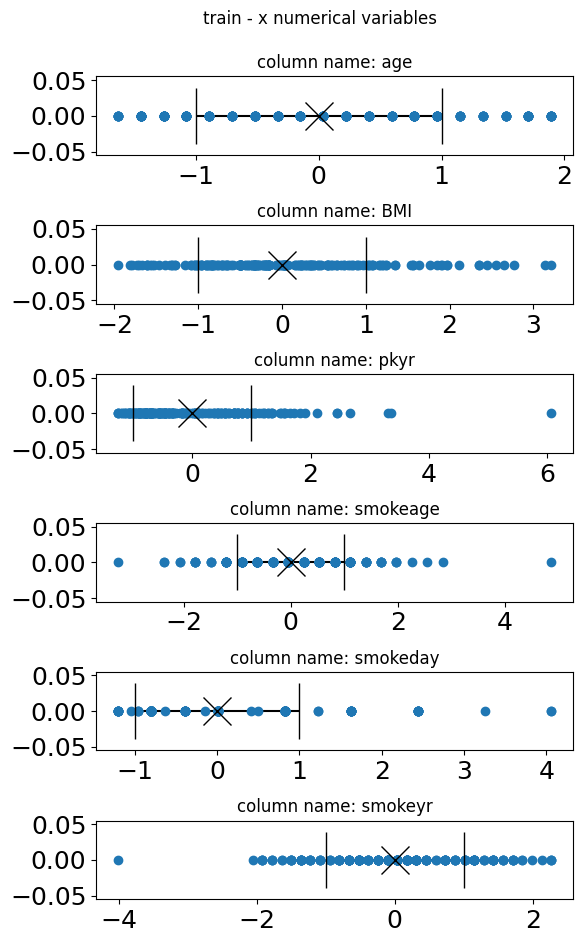

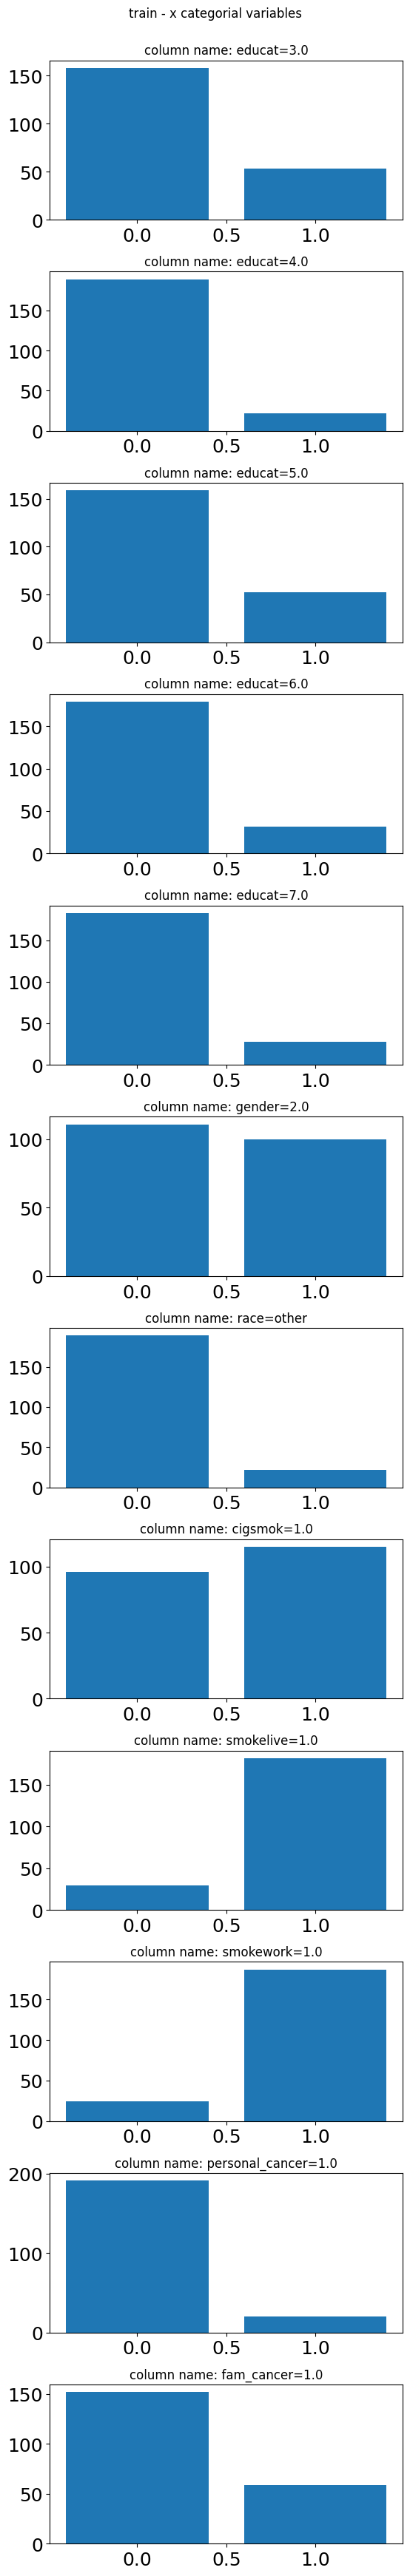

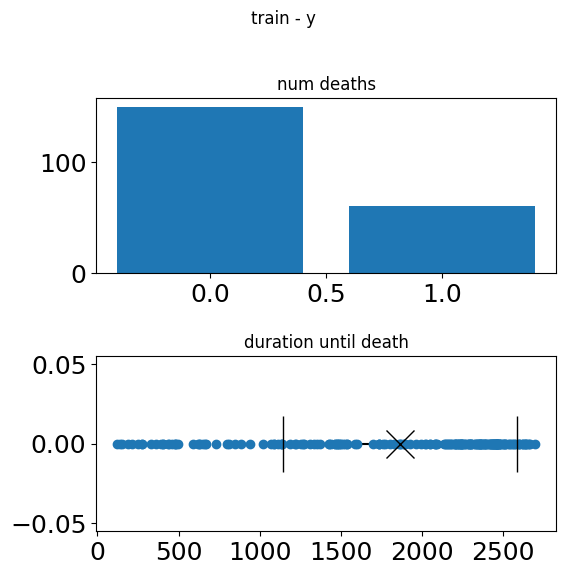

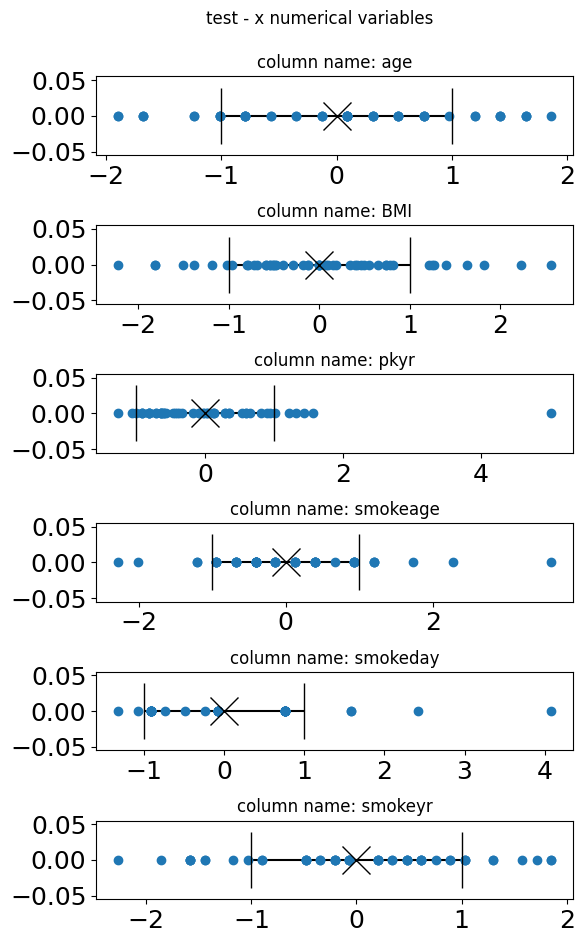

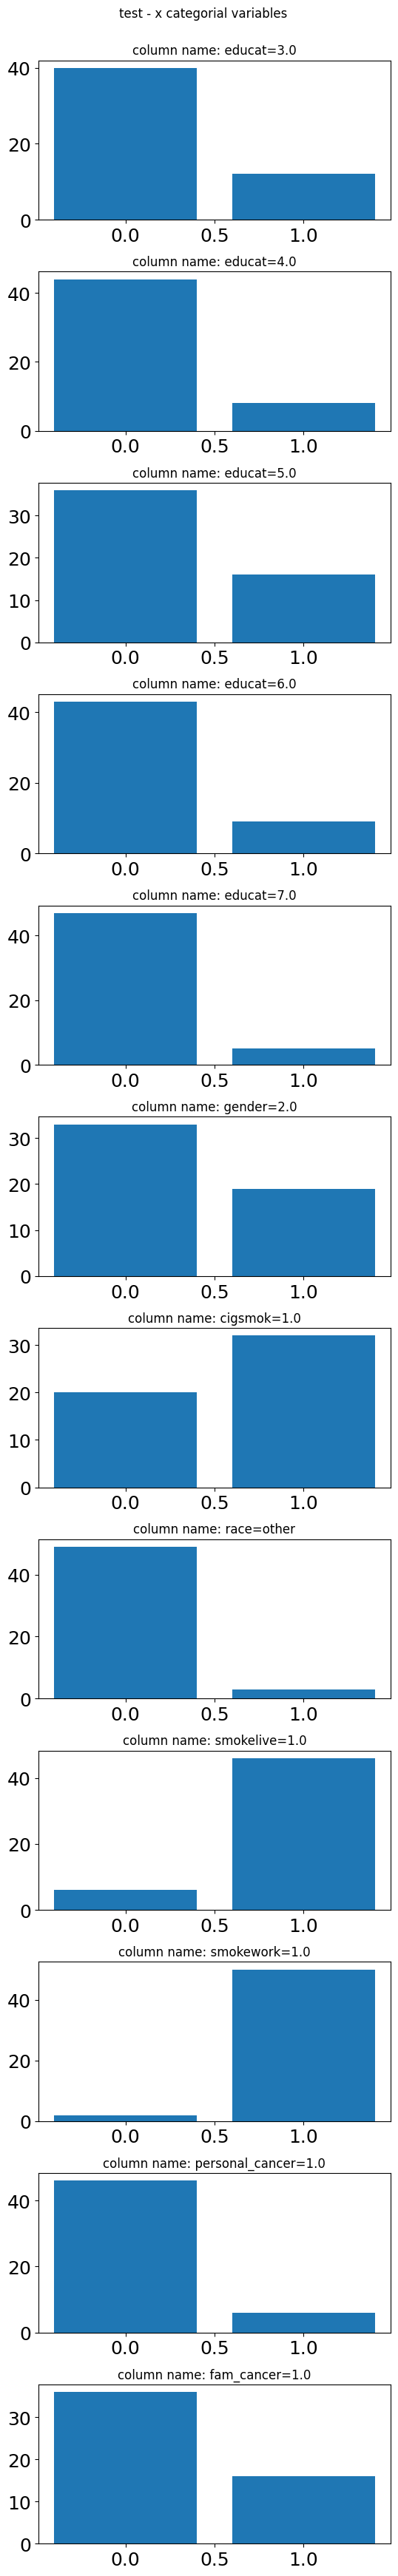

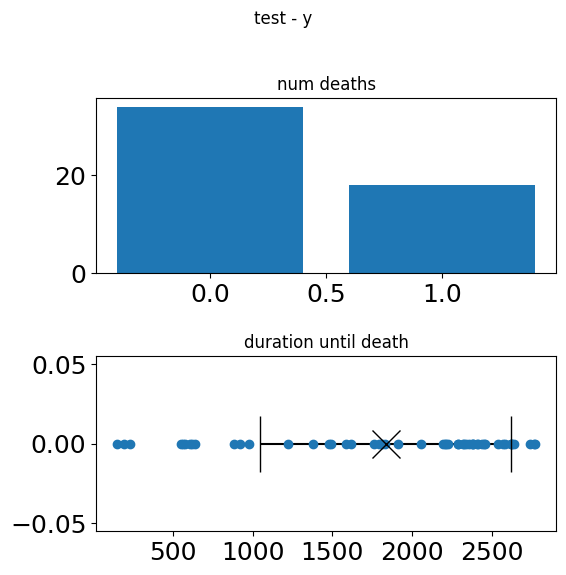

In [5]:
train_pos, val_pos, test_pos, _, _, _ = get_pids_split(data_root+'pids.txt')
pos_pids = np.array(train_pos + val_pos + test_pos)

kf = KFold(5, shuffle=True, random_state=1234)

categorical_vars = ["educat=3.0", "educat=4.0", "educat=5.0", "educat=6.0", "educat=7.0", "gender=2.0", "race=other", "cigsmok=1.0", "smokelive=1.0", "smokework=1.0", "personal_cancer=1.0", "fam_cancer=1.0"]

for split_idx, (train_index, test_index) in enumerate(kf.split(pos_pids)):
        
    train_pids = pos_pids[list(train_index)]
    test_pids = pos_pids[list(test_index)]

    prsndf = pd.read_csv(csv_path+'nlst_15kpct_prsn_062119.csv')
    prsndf = prsndf[prsndf['scr_group']== 1] # cancer positive

    pids_radiomics = []
    radiomics = []
    for f in file_list:
        pids_radiomics.append(int(f.split('/')[-1].split('.')[0]))
        radiomics.append(np.load(f)['arr_0'])
    radiomics =  np.array(radiomics)
    df_radiomics = pd.DataFrame(radiomics, columns=[str(i) for i in range(np.shape(radiomics)[1])], index=pids_radiomics)

    prsndf = prsndf[prsndf['pid'].isin(pids_radiomics)]
    prsndf_rad = prsndf.join(df_radiomics, on='pid')
    raddf = prsndf_rad.iloc[:,-107:]
    numericals = [str(i) for i in range (107)]

    #########################################################
    print("Clinical only:")
    x_train, y_train, df_train = parse_clinical(train_pids, prsndf)
    visualize_data(x_train, y_train, "train")
            
    x_test, y_test, df_test = parse_clinical(test_pids, prsndf)
    visualize_data(x_test, y_test, "test")
    
    x_test = x_test.reindex(columns=list(x_train))